<a href="https://colab.research.google.com/github/seunghak421/section2_project/blob/main/%08AI_13_%EB%B0%B1%EC%8A%B9%ED%95%99_section2_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

뇌졸중


In [11]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
data_stroke='/content/drive/MyDrive/Stroke.csv'

In [13]:
import pandas as pd
df=pd.read_csv(data_stroke)

In [14]:
df.dtypes

id                     int64
gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

In [15]:
df.isna().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

In [16]:
#이거 드롭하지말고 평균값으로 바꿀까??
df['bmi'] = df['bmi'].fillna(value=df['bmi'].mean())

In [17]:
df.isna().sum()

id                   0
gender               0
age                  0
hypertension         0
heart_disease        0
ever_married         0
work_type            0
Residence_type       0
avg_glucose_level    0
bmi                  0
smoking_status       0
stroke               0
dtype: int64

In [18]:
df.gender.replace({'Male':1,'Female':0,'Other':2},inplace = True)
df.ever_married.replace({'Yes':1,'No':0},inplace = True)
df.Residence_type.replace({'Urban':1,'Rural':0},inplace = True)

In [21]:
df=df.rename(columns={'ever_married':'married','avg_glucose_level':'glucose_level','smoking_status':'smoke','Residence_type':'Residence'})

In [33]:
df['smoke'].unique()

array(['formerly smoked', 'never smoked', 'smokes', 'Unknown'],
      dtype=object)

In [28]:
df['work_type']

0             Private
1       Self-employed
2             Private
3             Private
4       Self-employed
            ...      
5105          Private
5106    Self-employed
5107    Self-employed
5108          Private
5109         Govt_job
Name: work_type, Length: 5110, dtype: object

In [22]:
df.describe()

,id,gender,age,hypertension,heart_disease,married,Residence,glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000,5110.000000
mean,36517.829354,0.414286,43.226614,0.097456,0.054012,0.656164,0.508023,106.147677,28.893237,0.048728
std,21161.721625,0.493044,22.612647,0.296607,0.226063,0.475034,0.499985,45.283560,7.698018,0.215320
min,67.000000,0.000000,0.080000,0.000000,0.000000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,17741.250000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,77.245000,23.800000,0.000000
50%,36932.000000,0.000000,45.000000,0.000000,0.000000,1.000000,1.000000,91.885000,28.400000,0.000000
75%,54682.000000,1.000000,61.000000,0.000000,0.000000,1.000000,1.000000,114.090000,32.800000,0.000000
max,72940.000000,2.000000,82.000000,1.000000,1.000000,1.000000,1.000000,271.740000,97.600000,1.000000


In [34]:
target='stroke'

In [35]:
#프로젝트에 사용할 데이터는 뇌졸증 환자들에 관한 데이터 입나다.
#나이,성별,고혈압,심장질환,결혼여부,거주지,혈당,체질량,흡연여부로 데이터셋을 구성합니다.
#타겟은 뇌졸증 입니다.

In [36]:
df['stroke'].value_counts(normalize = True)
#클래스 2개 비율-> 불균형
#분류
#불균형 데이터 (accuracy만 사용해서는 안된다.)
#오차행렬,정밀도와 재현율,f1스코어,roc곡선과 auc등 을 같이 사용한다.

0    0.951272
1    0.048728
Name: stroke, dtype: float64

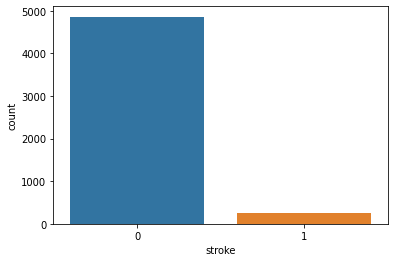

In [37]:
import seaborn as sns
tmp = df['stroke']
sns.countplot(x=tmp)

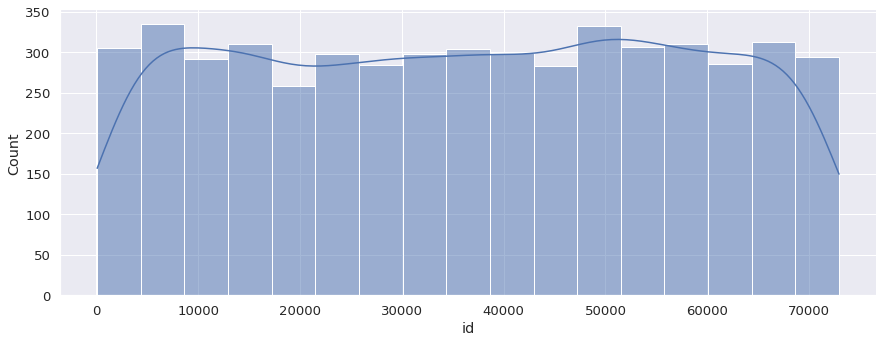

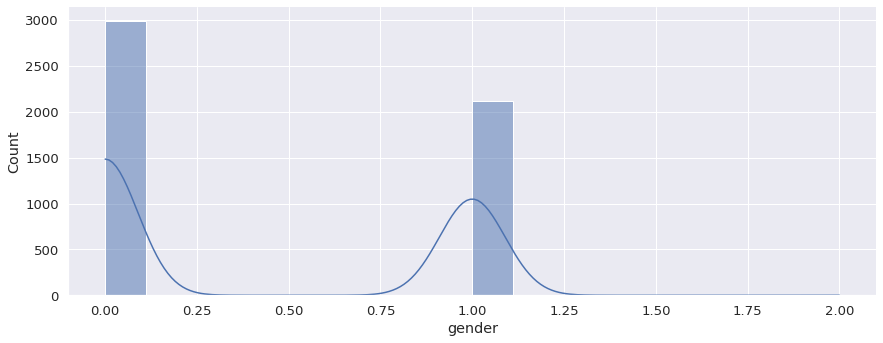

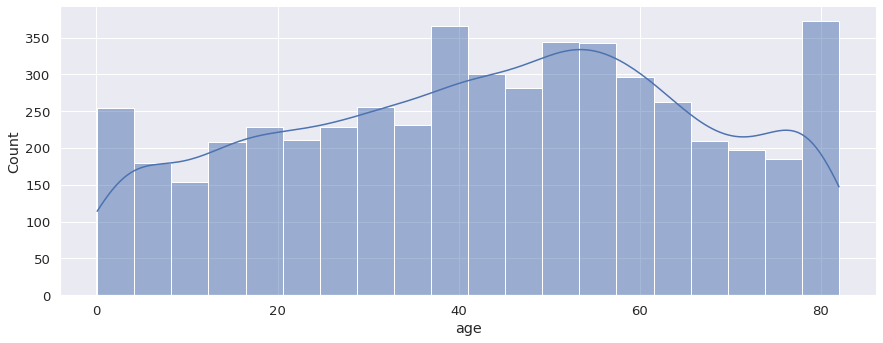

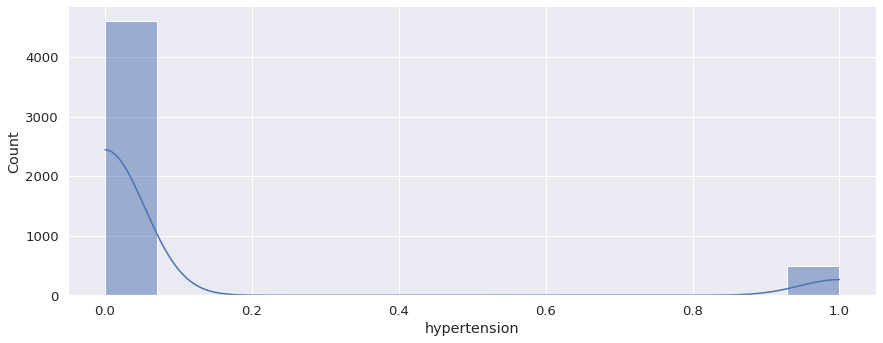

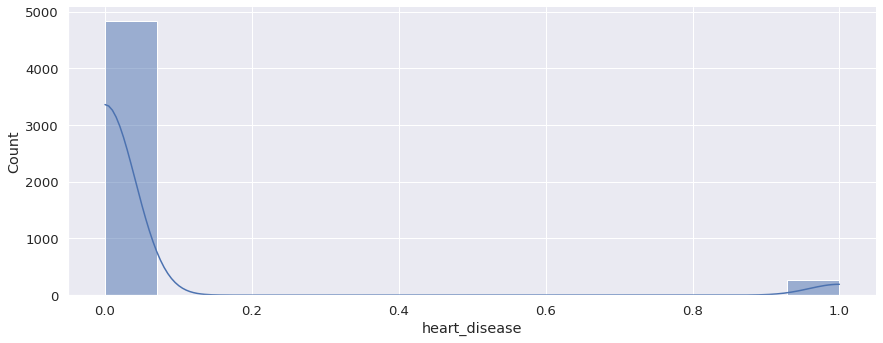

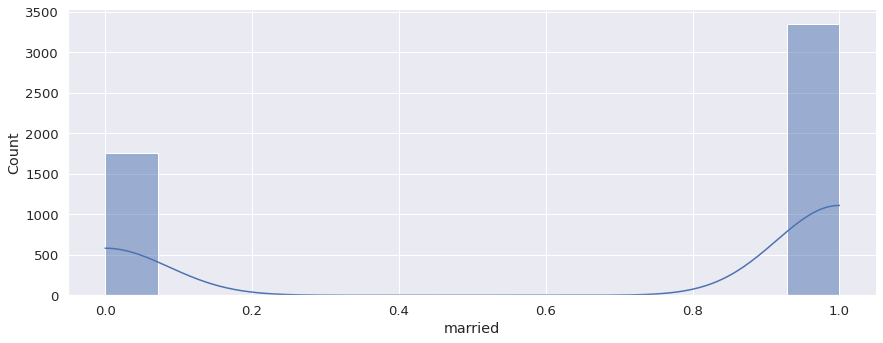

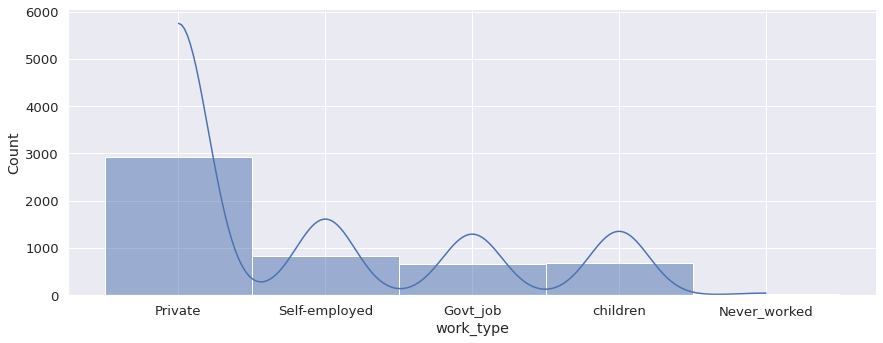

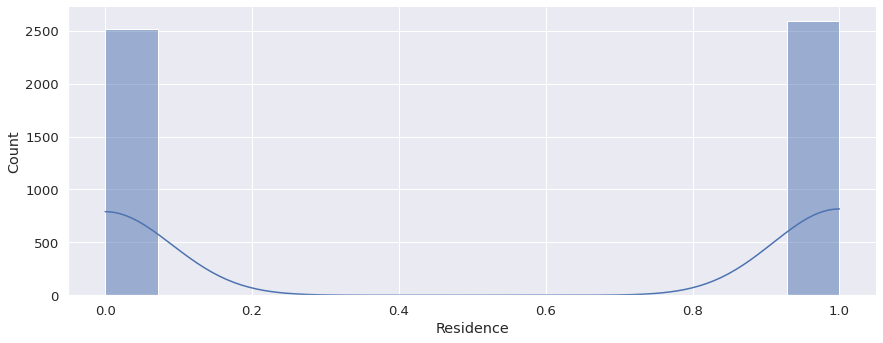

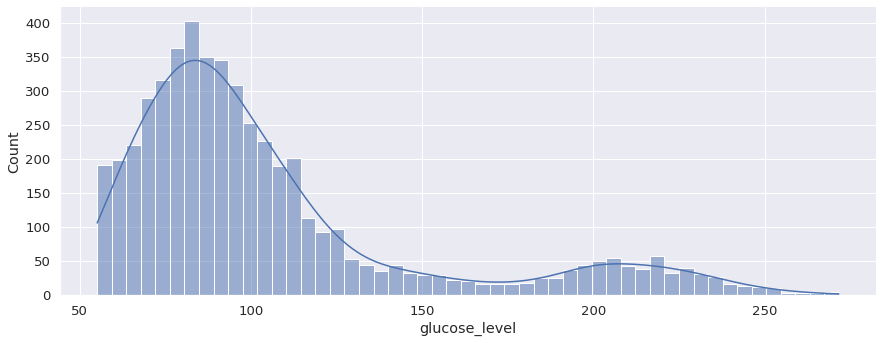

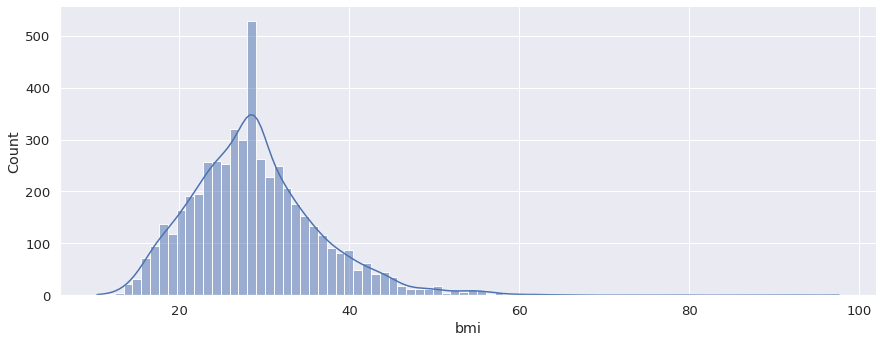

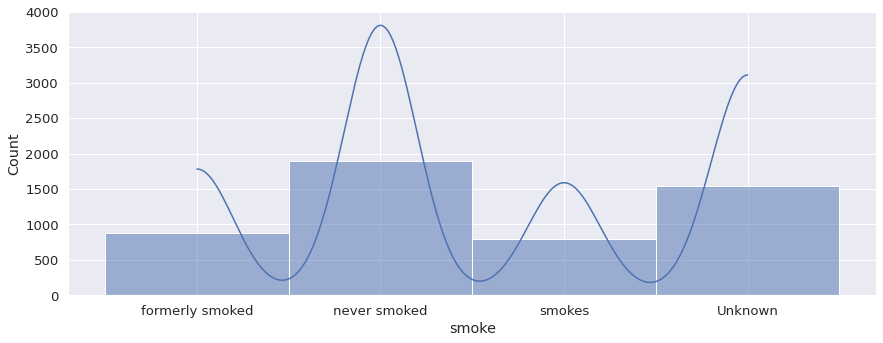

In [38]:
other = df.drop(['stroke'],axis=1).columns
sns.set(font_scale=1.2)

for i in other:
  sns.displot(df[i], height = 5, aspect = 2.5, kde=True);